In [120]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
import dali
from dali.data import Lines, Process, DiscoverFiles, BatchBenefactor, IdentityReducer
from dali.data.batch import TranslationBatch
from dali.data.translation import TranslationFiles, TranslationMapper, build_vocabs, iterate_examples
from dali.utils.scoring import bleu, ErrorTracker
from dali.utils import (
    Vocab,
    Solver,
    median_smoothing,
    subsample,
    Throttled,
    pickle_globals,
    unpickle_globals,
)
from dali import beam_search

%matplotlib inline

In [122]:
GPU_ID = 0
D.config.default_device = 'gpu'
D.config.default_gpu    = GPU_ID
print(D.config.gpu_id_to_name(GPU_ID))

b'Quadro K2000M'


In [160]:
generate_example(2, 4, 4)

[[
     [  1.000   0.000]
     [  1.000   0.000]
     [  0.000   1.000]
     [  1.000   0.000]
 ], [
     [  1.000   0.000]
     [  0.000   0.000]
     [  1.000   1.000]
     [  0.000   0.000]
 ], [
     [  1.000   1.000]
     [  0.000   1.000]
     [  1.000   1.000]
     [  0.000   0.000]
 ], [
     [  1.000   1.000]
     [  0.000   1.000]
     [  0.000   1.000]
     [  1.000   1.000]
 ]]

In [170]:
def generate_example(item_size, num_items, batch_size = 1):
    return [ D.Mat(np.random.binomial(1, 0.5, (batch_size, item_size)), dtype=np.float32) for _ in range(num_items) ]

def list_norm(xs):
    squared_sum = np.sqrt(sum((x.dw ** 2).sum() for x in xs))
    return squared_sum


def evaluate_copy(model, solver, input_size, max_train_seq_length, batch_size=1,
                  epochs=100000, curriculum_epochs=10000, debug=False):    
    start_prediction = D.Mat.ones((1,input_size), constant=True)
    
    def test(model, max_train_seq_length):
        with D.NoBackprop():
            for test_len in [max_train_seq_length // 2, max_train_seq_length, max_train_seq_length * 2]:
                print ("    Testing sequence length %d: " % (test_len,))

                NUM_TRIES = 10

                num_bits_correct = 0

                for _ in range(NUM_TRIES):
                    example = generate_example(input_size, test_len)
                    state = model.initial_states()
                    for input_vec in example:
                        state = model.activate(input_vec, state)

                    state = model.activate(start_prediction, state)
                    for input_vec in example:
                        decoded = np.round(model.decode(state).sigmoid().w)
                        num_bits_correct += sum(sum(np.abs(decoded - input_vec.w)))
                        state = model.activate(start_prediction, state)

                        
                print('        Cost per sequence: %f (chance: %f)' % (num_bits_correct / NUM_TRIES, 
                                                                      test_len * input_size / 2))
    
    params = model.parameters()
    
    not_too_often = Throttled(1)
    test_freqency = Throttled(30)
    errors = []
    
    recent_error = None;
    alpha = 0.95
    
    for epoch in range(epochs):
        try:
            max_len = int(max_train_seq_length * (epoch / curriculum_epochs)) + 1
            max_len = max(1, min(max_train_seq_length, max_len))

            example = generate_example(input_size, random.randint(1, max_len), BATCH_SIZE)
            state = model.initial_states()
            for input_vec in example:
                state = model.activate(input_vec, state)

            state = model.activate(start_prediction, state)
            error = D.Mat.zeros((1,1), constant=True)
            for input_idx, input_vec in enumerate(example):
                decoded = model.decode(state)
                #error = error + D.MatOps.sigmoid_binary_cross_entropy(decoded, input_vec).sum()
                error = error + ((decoded.sigmoid() - input_vec)**2).sum()
                if input_idx + 1 != len(example):
                    state = model.activate(start_prediction, state)

            (error / BATCH_SIZE).grad()
            D.Graph.backward()
            solver.step(params)
            
            errors.append(error.w[0,0] / BATCH_SIZE)
            if debug:
                return errors
            if not_too_often.should_i_run():
                recent_error = (errors[-1] if recent_error is None else recent_error) * alpha + errors[-1] * (1-alpha)
                print('Epoch %d (%d processed examples, curriculum: %d), error: %f' % (epoch, 
                                                                                       epoch*BATCH_SIZE,
                                                                                       max_len,
                                                                                       recent_error))
            if test_freqency.should_i_run():
                test(model, max_train_seq_length)
            if solver.solver_type == 'adagrad' and epoch % 1000 == 0:
                solver.reset_caches(params)
            
        except KeyboardInterrupt:
            print("Early stopping")
            test(model, max_train_seq_length)
            break
    test(model, max_train_seq_length)
    return errors
    

In [171]:
class LSTMBaseline(object):
    def __init__(self, input_size, hiddens, output_size):
        self.lstm    = D.StackedLSTM(input_size, hiddens)
        self.decoder = D.Layer(sum(hiddens), output_size)
        
    def activate(self, input_vec, previous_state):
        return self.lstm.activate(input_vec, previous_state)
    
    def decode(self, state):
        return self.decoder.activate(D.MatOps.hstack([s.hidden for s in state]))
    
    def parameters(self):
        return self.lstm.parameters() + self.decoder.parameters()
    
    def initial_states(self):
        return self.lstm.initial_states()

In [173]:
INPUT_SIZE           = 4
MAX_TRAIN_SEQ_LENGTH = 5


HIDDENS  = [256, 256, 256]
BATCH_SIZE  = 20
baseline_model = LSTMBaseline(INPUT_SIZE, HIDDENS, INPUT_SIZE)
##solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver("rmsprop", learning_rate=0.0001, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)

errors = evaluate_copy(baseline_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=10000, curriculum_epochs=5000)

Epoch 0 (0 processed examples, curriculum: 1), error: 0.998558
    Testing sequence length 2: 
        Cost per sequence: 4.900000 (chance: 4.000000)
    Testing sequence length 5: 
        Cost per sequence: 8.800000 (chance: 10.000000)
    Testing sequence length 10: 
        Cost per sequence: 19.800000 (chance: 20.000000)
Epoch 1 (20 processed examples, curriculum: 1), error: 0.998728
Epoch 37 (740 processed examples, curriculum: 1), error: 0.998720
Epoch 73 (1460 processed examples, curriculum: 1), error: 0.998736
Epoch 108 (2160 processed examples, curriculum: 1), error: 0.998297
Epoch 144 (2880 processed examples, curriculum: 1), error: 0.997381
Epoch 180 (3600 processed examples, curriculum: 1), error: 0.997023
Epoch 216 (4320 processed examples, curriculum: 1), error: 0.995774
Epoch 252 (5040 processed examples, curriculum: 1), error: 0.994375
Epoch 288 (5760 processed examples, curriculum: 1), error: 0.992565
Epoch 324 (6480 processed examples, curriculum: 1), error: 0.989766

In [175]:
class GRUBaseline(object):
    def __init__(self, input_size, hidden, output_size):
        self.seq    = D.GRU(input_size, hidden)
        self.decoder = D.Layer(hidden, output_size)
        
    def activate(self, input_vec, previous_state):
        return self.seq.activate(input_vec, previous_state)
    
    def decode(self, state):
        return self.decoder.activate(state)
    
    def parameters(self):
        return self.seq.parameters() + self.decoder.parameters()
    
    def initial_states(self):
        return self.seq.initial_states()

In [176]:
INPUT_SIZE           = 4
MAX_TRAIN_SEQ_LENGTH = 5


HIDDEN  = 256
BATCH_SIZE  = 20
baseline_model = GRUBaseline(INPUT_SIZE, HIDDEN, INPUT_SIZE)
##solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver("rmsprop", learning_rate=0.0001, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)

errors = evaluate_copy(baseline_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=10000, curriculum_epochs=5000)

Epoch 0 (0 processed examples, curriculum: 1), error: 1.007807
    Testing sequence length 2: 
        Cost per sequence: 3.900000 (chance: 4.000000)
    Testing sequence length 5: 
        Cost per sequence: 8.600000 (chance: 10.000000)
    Testing sequence length 10: 
        Cost per sequence: 20.400000 (chance: 20.000000)
Epoch 141 (2820 processed examples, curriculum: 1), error: 1.006281
Epoch 327 (6540 processed examples, curriculum: 1), error: 0.999587
Epoch 513 (10260 processed examples, curriculum: 1), error: 0.983540
Epoch 698 (13960 processed examples, curriculum: 1), error: 0.952478
Epoch 883 (17660 processed examples, curriculum: 1), error: 0.909743
Epoch 1055 (21100 processed examples, curriculum: 2), error: 0.864641
Epoch 1198 (23960 processed examples, curriculum: 2), error: 0.892634
Epoch 1337 (26740 processed examples, curriculum: 2), error: 0.900058
Epoch 1484 (29680 processed examples, curriculum: 2), error: 0.855162
Epoch 1628 (32560 processed examples, curriculum:

In [ ]:
from collections import defaultdict

class Capture(object):
    instances = set()
    
    def __init__(self):
        self.state = defaultdict(lambda: [])
        
    @classmethod
    def add(cls, name, value):
        for instance in cls.instances:
            instance.state[name].append(value)
    
    def __enter__(self):
        Capture.instances.add(self)
    
    def __exit__(self, *args, **kwargs):
        Capture.instances.remove(self)

In [ ]:
class MLP(object):
    def __init__(self, input_sizes, hiddens, nonlinearities):
        self.input_sizes = input_sizes
        self.hiddens = hiddens
        self.input_nonlinearity, self.layer_nonlinearities = nonlinearities[0], nonlinearities[1:]
        
        self.input_layer = D.StackedInputLayer(input_sizes, hiddens[0])
        self.layers = [D.Layer(h_from, h_to) for h_from, h_to in zip(hiddens[:-1], hiddens[1:])]
        
    def activate(self, inputs):
        assert len(self.layers) == len(self.layer_nonlinearities)
        hidden = self.input_nonlinearity(self.input_layer.activate(inputs))
        for l, nonlinearity in zip(self.layers, self.layer_nonlinearities):
            hidden = nonlinearity(l.activate(hidden))
        return hidden
    
    def parameters(self):
        ret = self.input_layer.parameters()
        for l in self.layers:
            ret.extend(l.parameters())
        return ret

In [177]:
def row_by_scalar(a,b):
    return D.MatOps.eltmul(a, b, broadcast=True, axis=0)

def col_by_scalar(a,b):
    return D.MatOps.eltmul(a, b, broadcast=True, axis=1)

class NTMAddressing(object):
    def __init__(self, input_sizes, memory_locations, memory_size, max_shifts=3):
        self.memory_locations = memory_locations
        self.content_key          = D.StackedInputLayer(input_sizes, memory_size)
        self.content_key_strength = D.StackedInputLayer(input_sizes, 1)
        self.interpolation        = D.StackedInputLayer(input_sizes, 1)
        self.shift                = D.StackedInputLayer(input_sizes, memory_locations)
        self.focus                = D.StackedInputLayer(input_sizes, 1)
        
        self.shift_mask = np.zeros((1, memory_locations))
        self.shift_mask[0, 0] = 1
        self.shift_mask[0, 1] = 1
        self.shift_mask[0, -1] = 1
        self.shift_mask = D.Mat(self.shift_mask)
        
    def content_addressing_activation(self, key, key_strength, memory):
        # cosine distance essentially
        key_broadcasted   = D.MatOps.broadcast(key, axis=0, num_replicas=memory.shape[0])
        unnormalized_dot  = (key * memory).sum(axis=1)
        key_norm          = key_broadcasted.L2_norm(axis=1)
        memory_norm       = memory.L2_norm(axis=1)
        cosine_similarity = (unnormalized_dot / (key_norm * memory_norm + 1e-6)).T()
        presoftmax        = row_by_scalar(cosine_similarity, key_strength)

        return D.MatOps.softmax(presoftmax)
        
    def address(self, inputs, memory, state):
        """Outputs memory location weights.
        
        Inputs:
        inputs -- set of vectors controlling the mechanism (e.g. LSTM output)
        state  -- weights from previous timestep.
        """
        # todo - should memory contents be tanhed?
        key                  = self.content_key.activate(inputs)
        key_strength         = self.content_key_strength.activate(inputs).softplus()
        # todo - make multiplication of similarity (vector) * key strength_scalrar is correctly broadcasted
        content_weights      = self.content_addressing_activation(key, key_strength, memory)
        interpolation_gate   = self.interpolation.activate(inputs).sigmoid()
        interpolated_weights = (row_by_scalar(content_weights, interpolation_gate) +
                                row_by_scalar(state,1.0 - interpolation_gate))        
        shift                = D.MatOps.softmax(self.shift.activate(inputs))
        shift                = shift * self.shift_mask
        shift                = shift / (shift.sum() + 1e-6)
        
        shifted_weighs       = D.MatOps.circular_convolution(interpolated_weights, shift)
        focus                = self.focus.activate(inputs).softplus() + 1.
        focused_weights      = shifted_weighs ** focus
        # todo - make sure it's correctly broadcasted
        sum_focused          = focused_weights.sum(axis=1)
        focused_weights      = focused_weights / (sum_focused + 1e-6)
        return focused_weights
    
    def initial_states(self):
        with D.NoBackprop():
            return D.MatOps.softmax(D.random.uniform(-1,1, (1,self.memory_locations)))
    
    def parameters(self):
        res = []
        res.extend(self.content_key.parameters())
        res.extend(self.content_key_strength.parameters())
        res.extend(self.interpolation.parameters())
        res.extend(self.shift.parameters())
        res.extend(self.focus.parameters())
        return res

class NTMReadHead(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.addressing = NTMAddressing(input_sizes, memory_locations, memory_size)
    
    def read(self, inputs, memory, state):
        weights = self.addressing.address(inputs, memory, state)
        Capture.add("read_head_weights", weights)
        # todo - make sure it is correctly broadcasted
        pulled_from_memory = row_by_scalar(memory, weights.T()).sum(axis=0)
        Capture.add("read_head_content", pulled_from_memory)
        return pulled_from_memory, weights
    
    def initial_states(self):
        return self.addressing.initial_states()
    
    def parameters(self):
        return self.addressing.parameters()


class NTMWriteHead(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.addressing = NTMAddressing(input_sizes, memory_locations, memory_size)
        self.content    = D.StackedInputLayer(input_sizes, memory_size)
        self.erase      = D.StackedInputLayer(input_sizes, memory_size)
        
    def write(self, inputs, memory, state):
        weights = self.addressing.address(inputs, memory, state)
        Capture.add("write_head_weights", weights)

        # todo - make sure it is correctly broadcasted
        new_content = self.content.activate(inputs)
        Capture.add("write_head_content", new_content)

        erase       = self.erase.activate(inputs).sigmoid()
        
        memory = memory * (1.0 - weights.T().dot(erase))
        # todo - make sure it is an outer product
        memory = memory + weights.T().dot(new_content)
        return memory, weights
    
    def initial_states(self):
        return self.addressing.initial_states()
    
    def parameters(self):
        return self.addressing.parameters()
    

In [195]:
class NTM(object):
    def __init__(self, input_size, hiddens, output_size, 
                 num_read_heads, num_write_heads,
                 memory_locations, memory_size,
                 controller_type='lstm'):
        self.memory_locations = memory_locations
        self.memory_size      = memory_size
        self.controller_type  = controller_type
        
        controller_inputs = [input_size] + [memory_size for _ in range(num_read_heads)]
        if controller_type   == 'mlp':
            nonlinearities = [D.MatOps.tanh for _ in range(len(hiddens))]
            self.controller = MLP(controller_inputs, hiddens, nonlinearities)
            self.controller_output_size = [hiddens[-1]]
        elif controller_type == 'lstm':
            self.controller = D.StackedLSTM(controller_inputs, hiddens, memory_feeds_gates=True)
            self.controller_output_size = hiddens
    
        self.decoder      = D.StackedInputLayer(self.controller_output_size, output_size)
        self.read_heads   = [NTMReadHead (self.controller_output_size, memory_locations, memory_size) 
                                 for _ in range(num_read_heads) ]
        self.write_heads  = [NTMWriteHead(self.controller_output_size, memory_locations, memory_size) 
                                 for _ in range(num_write_heads)]

    def activate(self, input_vec, state):
        # read
        new_read_heads_state = []
        read_from_memory     = []
        for head, head_state in zip(self.read_heads, state['read_heads']):
            content, new_head_state = head.read(self.extract_hiddens(state['controller']), 
                                                state['memory'],
                                                head_state)
            read_from_memory.append(content)
            new_read_heads_state.append(new_head_state)
        # activate
        if self.controller_type   == 'mlp':
            new_controller_state = self.controller.activate([input_vec] + read_from_memory)
        elif self.controller_type == 'lstm':
            new_controller_state = self.controller.activate([input_vec] + read_from_memory, state['controller'])

        # write
        new_memory = state['memory']
        new_write_heads_state = []
        for head, head_state in zip(self.write_heads, state['write_heads']):
            new_memory, new_head_state = head.write(self.extract_hiddens(new_controller_state),
                                                    new_memory,
                                                    head_state)
            new_write_heads_state.append(new_head_state)
        # collect results
        new_state = {
            'read_heads'           : new_read_heads_state,
            'write_heads'          : new_write_heads_state,
            'memory'               : new_memory,
            'controller'           : new_controller_state
        }

        return new_state
    
    def decode(self, state):
        return self.decoder.activate(self.extract_hiddens(state['controller']))
        
    def parameters(self):
        res = []
        res.extend(self.controller.parameters())
        res.extend(self.decoder.parameters())
        for head in self.read_heads:
            res.extend(head.parameters())
        for head in self.write_heads:
            res.extend(head.parameters())
        return res
    
    def extract_hiddens(self, state):
        if self.controller_type   == 'mlp':
            return [state]
        elif self.controller_type == 'lstm':
            return [s.hidden for s in state]
    
    def initial_states(self):
        with D.NoBackprop():
            memory_init = D.MatOps.softmax(D.random.uniform(0.1, -0.1, (self.memory_locations, self.memory_size)))
        
        ret = {
            'read_heads':            [head.initial_states() for head in self.read_heads],
            'write_heads':           [head.initial_states() for head in self.write_heads],
            'memory':                memory_init,            
        }
        if self.controller_type   == 'mlp':
            ret['controller'] = D.Mat.ones((1, self.controller_output_size[0]))
        elif self.controller_type == 'lstm':
            ret['controller'] = self.controller.initial_states()
        
        return ret

In [196]:
INPUT_SIZE           = 1
MAX_TRAIN_SEQ_LENGTH = 1


HIDDENS          = [10]
BATCH_SIZE       = 1
MEMORY_LOCATIONS = 12
MEMORY_SIZE      = 2
ntm_model = NTM(input_size=INPUT_SIZE,
                hiddens=HIDDENS,
                output_size=INPUT_SIZE,
                num_read_heads=1,
                num_write_heads=1,
                memory_locations=MEMORY_LOCATIONS,
                memory_size=MEMORY_SIZE,
                controller_type='mlp')


In [ ]:
#solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver("rmsprop", learning_rate=1e-5, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)
#solver = Solver("sgd", learning_rate=1e-2, clipval=10.0)
# solver = Solver("adagrad", learning_rate=0.00001, clipval=10.0)

errors = evaluate_copy(ntm_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=100990, debug=False)

Epoch 0 (0 processed examples, curriculum: 1), error: 0.168475
    Testing sequence length 0: 
        Cost per sequence: 0.000000 (chance: 0.000000)
    Testing sequence length 1: 
        Cost per sequence: 0.200000 (chance: 0.500000)
    Testing sequence length 2: 
        Cost per sequence: 1.000000 (chance: 1.000000)
Epoch 97 (97 processed examples, curriculum: 1), error: 0.177194

dict_keys(['write_head_weights', 'write_head_content', 'read_head_content', 'read_head_weights'])
At tstep 0 READ: 0.091, WRITE: 0.091
At tstep 1 READ: 0.090, WRITE: 0.090
At tstep 2 READ: 0.089, WRITE: 0.089


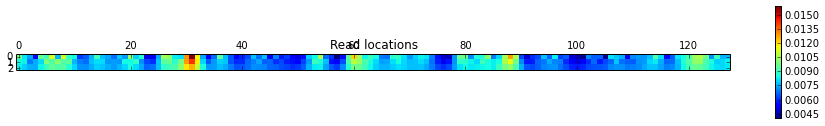

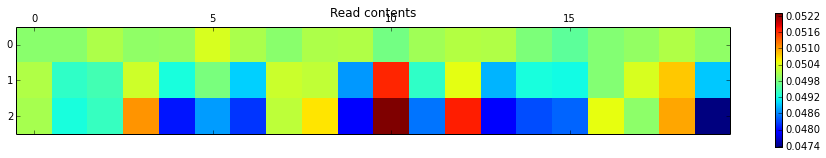

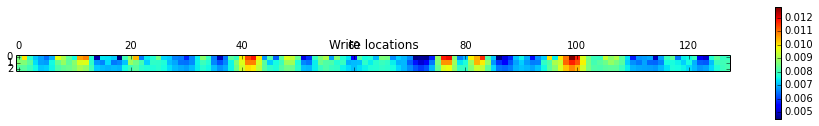

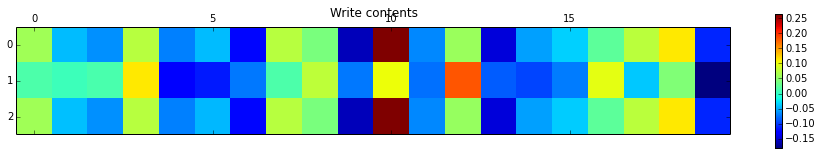

In [186]:
def combine_access(accesses):
    num_accesses = len(accesses)
    assert(num_accesses > 0)
    mem_locations = accesses[0].shape[1]
    res = np.zeros((num_accesses, mem_locations))
    norms = []
    for idx, access in enumerate(accesses):
        assert(access.shape == (1, mem_locations))
        res[idx] = access.w[0]
        norms.append(np.linalg.norm(access.w[0]))
    return res, norms

def inspect(model):
    empty_input      = D.Mat.zeros((1,INPUT_SIZE), constant=True)
    start_prediction = D.Mat.ones((1,INPUT_SIZE), constant=True)
    c = Capture()
    with D.NoBackprop():
        with c:
            example = generate_example(INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH)
            state = model.initial_states()
            for input_vec in example:
                state = model.activate(input_vec, state)

            state = model.activate(start_prediction, state)
            for input_vec in example:
                decoded = np.round(model.decode(state).sigmoid().w)
                state = model.activate(empty_input, state)
    reads, read_norms  = combine_access(c.state["read_head_weights"])
    writes, write_norms = combine_access(c.state["write_head_weights"])
    
    print(c.state.keys())
    
    plt.figure()
    r = plt.matshow(reads)
    plt.title("Read locations")
    plt.colorbar(r)
    
    read_contents, _ = combine_access(c.state["read_head_content"])
    plt.figure()
    r = plt.matshow(read_contents)
    plt.title("Read contents")
    plt.colorbar(r)
    
    plt.figure()
    w = plt.matshow(writes)
    plt.title("Write locations")
    plt.colorbar(w)
    
    write_contents, _ = combine_access(c.state["write_head_content"])
    plt.figure()
    r = plt.matshow(write_contents)
    plt.title("Write contents")
    plt.colorbar(r)
    
    for idx, (read_n, write_n) in enumerate(zip(read_norms, write_norms)):
        print("At tstep %d READ: %.3f, WRITE: %.3f" % (idx, read_n, write_n))

inspect(ntm_model)

In [ ]:
c.state["read_head"][1].shape

In [ ]:
ntm_model.__class__ = NTM
for h in ntm_model.read_heads:
    h.__class__ = NTMReadHead
for h in ntm_model.write_heads:
    h.__class__ = NTMWriteHead

In [ ]:
ntm_model.write_heads[0].__class__ = NTMWriteHead

In [ ]:
A = D.Mat([[1,1,1],[2,2,2]])
B = D.Mat([[1,2,3]])

In [ ]:
print(A.w)
print(B.w)
A/ D.MatOps.broadcast(B, axis=0, num_replicas=2)

In [ ]:
A.w.mean(axis=0)

In [ ]:
A.softplus()

In [ ]:
A = D.Mat([1,2,3])

In [ ]:
D.Mat([1,2,3]) * D.Mat([2])

In [ ]:
x = D.random.uniform(-1,1, (1,1)).sum(0)

In [ ]:
D.MatOps.broadcast(x, axis=0, num_replicas=20)

In [ ]:
x = D.random.uniform(-1,1, (1,2))
y = D.random.uniform(-1,1, (1,3))

In [ ]:
x

In [ ]:
y

In [ ]:
y.dot(x)

In [ ]:
ax = plt.subplots(2,2)

In [ ]:
ax

In [ ]:
1.0 - D.Mat.ones((2,3))